Notebook prepared by Henrique Lopes Cardoso (hlc@fe.up.pt).

# TEXT CLASSIFICATION

## Original dataset

For text classification, let's make use of a dataset of restaurant reviews, which can be used for a simple sentiment analysis task: each review is either positive (1) or negative (0).

In [7]:
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


We can start by observing label distribution:

1    500
0    500
Name: Liked, dtype: int64
1    0.5
0    0.5
Name: Liked, dtype: float64


<AxesSubplot:>

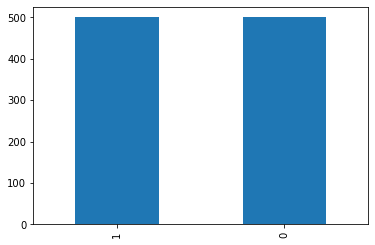

In [8]:
print(dataset['Liked'].value_counts())

print(dataset['Liked'].value_counts(normalize=True))

dataset['Liked'].value_counts().plot(kind='bar')

## Cleanup and normalization

A typical first step when addressing text classification is to apply a few techniques to cleanup and normalize the text.

We can start by quickly inspecting the contents of reviews. Print them all and try finding opportunities for cleanup and normalization operations.

In [ ]:
# your code here


So, you've probably been able to find non-alphabetic characters (including punctuation), capitalized words (sometimes even whole reviews), and so on.

#### Removing non-alphabetic chars

Let's start by removing any non-alpha chars, using a regular expression. We'll create a separate corpus (a list of reviews), so that we leave the original dataset untouched.

In [ ]:
import re

corpus = []
for i in range(0, dataset['Review'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    # add review to corpus
    corpus.append(review)

print(corpus)

#### Lowercasing

We can then apply lowercasing, so that words such as *Amazing*, *AMAZING* and *amazing* all have the same representation.

In [ ]:
# your code here


#### Removing stop words

Another common step which is sometimes applied is to remove any stop words (words that do not have domain semantics attached). We can use the stop words list provided in NLTK for English:

In [ ]:
from nltk.corpus import stopwords

print(stopwords.words('english'))

Using this stop word list (which does include words that perhaps we should *not* remove, such as negation terms), we can considerably reduce the size of our corpus.

In [ ]:
# your code here


This technique does not always enable machine learning classifiers to do better, as most of them are quite immune to the presence of stop words (which anyway tend not to be discriminative of the classes at hand). But in any case, removing stop words does reduce the size of the corpus.

Can you check how smaller the corpus has become by removing stop words? (You might need to go back and get the size of the corpus *before* removing stop words, for comparison.)

In [ ]:
# your code here


#### Stemming

Finally, we can apply stemming to further reduce the size of the vocabulary through normalization.

In [ ]:
# your code here


Can you check how much has the vocabulary been reduced by applying stemming? (You might need to go back one step and get the size of the vocabulary *before* applying stemming, for comparison.)

In [ ]:
# your code here


#### Doing it all in one step

Of course, instead of applying each of the aforementioned steps one at a time, it would be much more efficient to do it in a single loop. Here's the compact version for employing non-alphabetic filtering, lowercasing, stop word removal, and stemming.

In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []
ps = PorterStemmer()
for i in range(0, dataset['Review'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([ps.stem(w) for w in review.split() if not w in set(stopwords.words('english'))])
    corpus.append(review)

print(corpus)

['wow love place', 'crust good', 'tasti textur nasti', 'stop late may bank holiday rick steve recommend love', 'select menu great price', 'get angri want damn pho', 'honeslti tast fresh', 'potato like rubber could tell made ahead time kept warmer', 'fri great', 'great touch', 'servic prompt', 'would go back', 'cashier care ever say still end wayyy overpr', 'tri cape cod ravoli chicken cranberri mmmm', 'disgust pretti sure human hair', 'shock sign indic cash', 'highli recommend', 'waitress littl slow servic', 'place worth time let alon vega', 'like', 'burritto blah', 'food amaz', 'servic also cute', 'could care less interior beauti', 'perform', 'right red velvet cake ohhh stuff good', 'never brought salad ask', 'hole wall great mexican street taco friendli staff', 'took hour get food tabl restaur food luke warm sever run around like total overwhelm', 'worst salmon sashimi', 'also combo like burger fri beer decent deal', 'like final blow', 'found place accid could happier', 'seem like go

#### Wordclouds

A visually appealing way of observing words in a corpus is by showing wordclouds. In order to make a single wordcloud for the whole corpus, we can join all reviews together. We then pass it to [WordCloud](https://amueller.github.io/word_cloud/) to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

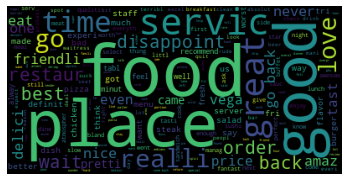

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the classes. Can you do it?

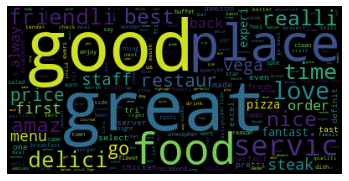

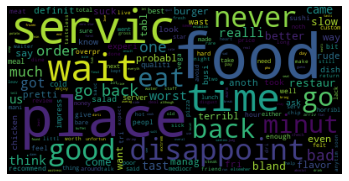

In [12]:
# your code here
    
liked = []
disliked = []
for i in range(0, dataset['Review'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([ps.stem(w) for w in review.split() if not w in set(stopwords.words('english'))])
    if dataset['Liked'][i] == 1:
        liked.append(review)
    else:
        disliked.append(review)
        

wordcloud_liked = WordCloud().generate(" ".join(liked))
wordcloud_disliked = WordCloud().generate(" ".join(disliked))

plt.figure()
plt.imshow(wordcloud_liked)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(wordcloud_disliked)
plt.axis('off')
plt.show()



## Generating a data set

We need to transform the data in the reduced-vocabulary corpus into a dataset that can be handled by machine learning models. Each review in our corpus is still rather unstructured: it is simply a lists of tokens. We will transform each review into a representation that makes use of the same set of features for the whole dataset.

#### Obtaining features from the Bag-of-Words model

The simplest way to do it is to create a *bag-of-words* model, which ignores word sequence.

We can use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which converts a collection of text documents to a matrix of token counts.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)

(1000, 1565)


By using CountVectorizer, we can limit the number of features by using the *max_features* parameter.

Let's look at the features we've got:

In [14]:
print(vectorizer.get_feature_names())

['absolut', 'absolutley', 'accid', 'accommod', 'accomod', 'accordingli', 'account', 'ach', 'acknowledg', 'across', 'actual', 'ad', 'afford', 'afternoon', 'ago', 'ahead', 'airlin', 'airport', 'ala', 'albondiga', 'allergi', 'almond', 'almost', 'alon', 'also', 'although', 'alway', 'amaz', 'ambianc', 'ambienc', 'amount', 'ampl', 'andddd', 'angri', 'annoy', 'anoth', 'anticip', 'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'apart', 'apolog', 'app', 'appal', 'appar', 'appeal', 'appet', 'appetit', 'appl', 'approv', 'area', 'arepa', 'aria', 'around', 'array', 'arriv', 'articl', 'ask', 'assur', 'ate', 'atmospher', 'atroci', 'attach', 'attack', 'attent', 'attitud', 'auju', 'authent', 'averag', 'avocado', 'avoid', 'aw', 'away', 'awesom', 'awkward', 'awkwardli', 'ayc', 'az', 'baba', 'babi', 'bachi', 'back', 'bacon', 'bad', 'bagel', 'bakeri', 'baklava', 'ball', 'bamboo', 'banana', 'bank', 'bar', 'bare', 'bargain', 'bartend', 'base', 'basebal', 'basic', 'batch', 'bathroom', 'batter', 'bay', 'bbq', 

C:\Users\Joana\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Each review is now represented as a vector with the number of occurrences for each of the features, indicating how many times the corresponding token appears in the review. Each vector is very sparse.

Compare the contents of the 124th review with its representation vector following the bag-of-words model.

In [25]:
# your code here

print(corpus[124])
print(X[124])

thought ventur away get good sushi place realli hit spot night
[0 0 0 ... 0 0 0]


#### Obtaining the classes

We can get the target labels from the second column in our original dataset, after which we have the full table of data on which we can train machine learning algorithms that are able to classify restaurant reviews into either positive or negative.

In [26]:
y = dataset['Liked']

print(X.shape, y.shape)

(1000, 1565) (1000,)


## Training classifiers

To train machine learning classifiers, we first split the data into training and test sets.

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(800, 5634) (800,)
(200, 5634) (200,)

Label distribution in the training set:
0    403
1    397
Name: Liked, dtype: int64

Label distribution in the test set:
1    103
0     97
Name: Liked, dtype: int64


Every time you perform the train-test split, you get slightly different results in terms of class distribution. To avoid it, you can use the *random_state* parameter for *train_test_split* (e.g. *random_state = 0*), which ensures you always get the same exact split.

You can also force a stratified split via parameter *stratify*, which ensures the same label distribution for both the training and test sets (*stratify=y*).

#### Naive Bayes

We can start by trying out fitting a [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) classifier to our training data. For text data, the two most effective variants are [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and [ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html).

In [102]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

Let's see the model's output on the test set:

In [103]:
y_pred = clf.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0
 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0
 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1]


We can assess the performance of the model by looking at different metrics.

We can print the *confusion matrix*, and get scores for *accuracy*, *precision*, *recall*, and *f1*. Since our dataset is perfectly balanced, accuracy will be a fairly good indicator of performance.

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# confusion matrix
print(confusion_matrix(y_test, y_pred))

# accuracy, precision, recall, f1
# your code here
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


[[75 22]
 [26 77]]
0.76
0.7777777777777778
0.7475728155339806
0.7623762376237624


Let's do a test on a review obtained from the user. We ask the user for input, preprocess the inserted review by removing non-alphabetic characters and by applying lowercasing and stemming

We then vectorize the review using the same vectorizer we've used before for creating the dataset. Note that we do not need to remove stop words, as these will be ignored by the vectorizer, since they do not show up in the feature set used to represent reviews.

In [41]:
import os

rev = input("Enter review: ")

# remove non alpha chars, apply lowercasing
# your code here
# get review and remove non alpha chars
rev = re.sub('[^a-zA-Z]', ' ', rev)
# to lower-case
rev = rev.lower()

# split into tokens and apply stemming
# your code here
# split into tokens, apply stemming and remove stop words
rev = ' '.join([ps.stem(w) for w in rev.split() if not w in set(stopwords.words('english'))])

# vectorize the review
V = vectorizer.transform([rev]).toarray()

print(rev)
print(V.shape)
print(V)

if(clf.predict(V) == [1]):
    print('positive review (+)')
else:
    print('negative review (-)')

Enter review: very competent
compet
(1, 1565)
[[0 0 0 ... 0 0 0]]
negative review (-)


Many classifiers also provide probabilities for each possible class when making predictions. We can get them by using *predict_proba* instead of *predict*:

In [42]:
print(clf.predict(V))
print(clf.predict_proba(V))

[0]
[[0.50375 0.49625]]


#### Other classifiers

Try out using other classifiers, such as:
- *Logistic Regression*, through scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class.
- *Decision Tree*, through scikit-learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class. This model always assigns a probability of 1 to one of the classes.
- *Random Forest*, through scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class.
- *Support Vector Machines (SVM)*, through scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class. The SVM model also allows you to get probabilities, but for that you need to use the *probability=True* parameter setting in its constructor.
- *Perceptron*, through scikit-learn's [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) class. This model does not allow you to get probabilities.
- *eXtreme Gradient Boosting*, through [XGBoost](https://xgboost.readthedocs.io/en/stable/).

In [50]:
# your code here
from sklearn.linear_model import Perceptron


lg = Perceptron(tol=1e-3, random_state=0)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)

# confusion matrix
print(confusion_matrix(y_test, y_pred))

# accuracy, precision, recall, f1
# your code here
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.98875
[[79 18]
 [36 67]]
0.73
0.788235294117647
0.6504854368932039
0.7127659574468085


#### Cross-validation

When addressing datasets that are not big enough, cross-validation allows us to use the whole dataset for both training and testing, by splitting the data into *k* folds. By training the model *k* times, each time using *k-1* folds and testing in the remaining fold, we can get performance scores for the model that are averaged accross the *k* iterations.

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf = SVC()
scores = cross_val_score(clf, X, y, cv=10)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.68 0.74 0.74 0.81 0.74 0.83 0.84 0.82 0.77 0.84]
0.78 accuracy with a standard deviation of 0.05


The [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) class allows greated flexibility in terms of the metrics we can get, and also provides train scores, fit times and score times.

In [52]:
from sklearn.model_selection import cross_validate

scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], return_train_score=True)
scores

{'fit_time': array([0.63054538, 0.58083367, 0.72070813, 0.83735251, 0.91333699]),
 'score_time': array([0.22887826, 0.35699487, 0.28073072, 0.31983256, 0.34656072]),
 'test_accuracy': array([0.73 , 0.775, 0.745, 0.825, 0.775]),
 'train_accuracy': array([0.9675 , 0.9575 , 0.9675 , 0.96125, 0.965  ]),
 'test_precision_macro': array([0.73770153, 0.79662388, 0.76749645, 0.82898067, 0.78318402]),
 'train_precision_macro': array([0.9682492 , 0.95823317, 0.96779237, 0.96208464, 0.96557032]),
 'test_recall_macro': array([0.73 , 0.775, 0.745, 0.825, 0.775]),
 'train_recall_macro': array([0.9675 , 0.9575 , 0.9675 , 0.96125, 0.965  ]),
 'test_f1_macro': array([0.72779514, 0.77082325, 0.73952348, 0.82446902, 0.77336254]),
 'train_f1_macro': array([0.96748699, 0.95748299, 0.96749492, 0.96123249, 0.96498928])}

## Beyond bag-of-words

We can use other forms of representing the text in our dataset. For instance, we can compute the occurrence of words in a different way. And we can consider features beyond simple words.

#### 1-hot vectors

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) includes a parameter (*binary*) that allows us to represent each review as a 1-hot vector with a 0 or a 1 for each of the features, indicating whether the corresponding token appears in the review.

Can you try it out? Compare the previous representation vector of the 124th review with its 1-hot representation vector.

In [97]:
# your code here
vectorizer1 = CountVectorizer()
rev = corpus[124].split()
X = vectorizer1.fit_transform(corpus).toarray()
X1 = vectorizer1.transform(rev)
print(X1)


  (0, 1389)	1
  (1, 1476)	1
  (2, 74)	1
  (3, 578)	1
  (4, 594)	1
  (5, 1348)	1
  (6, 1028)	1
  (7, 1110)	1
  (8, 665)	1
  (9, 1288)	1
  (10, 914)	1


#### TF-IDF

We can adjust the counts of each word in a document by considering how many times it occurs in the document (its *term frequency TF*) and in how many documents it occurs (its *document frequency DF*). [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) provides a way to directly obtain TF-IDF weighted features: the term frequency of a word is multiplied by its *inverse* document frequency.

Can you try it out? Compare the previous representation vector of the 124th review with its TF-IDF representation vector.

In [98]:
# your code here
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform(corpus)
X1 = vectorizer2.transform(rev)
print(X1)

  (0, 1389)	1.0
  (1, 1476)	1.0
  (2, 74)	1.0
  (3, 578)	1.0
  (4, 594)	1.0
  (5, 1348)	1.0
  (6, 1028)	1.0
  (7, 1110)	1.0
  (8, 665)	1.0
  (9, 1288)	1.0
  (10, 914)	1.0


Using TF-IDF weighing gives us a particularly interesting perspective on wordcloud visualizations. For that, we sum directly the values for each feature in the samples we want, and pass these values to [WordCloud](https://amueller.github.io/word_cloud/) as a python dict (containing each word and its frequency) using [generate_from_frequencies](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html). Can you do it?

In [ ]:
# your code here


#### N-grams

The bag-of-words model is very simplistic and ignores word order. Perhaps we can do better if we make use of a bi-gram representation: generate features corresponding to pairs of consecutive tokens. Hopefully, in some cases we will be able to distinguish negations, such as in *not expensive* vs *expensive*.

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (and also [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) includes the *ngram_range* parameter, which we can use to define the range of n-grams we want to generate as features. If we use a range (1,2), for instance, we'll get both individual tokens as well as bi-grams. Perhaps when doing so it will be a good idea not to get rid of stop words, since the stop word list we have used before includes negation tokens.

Can you try it out?

In [100]:
vectorizer1 = TfidfVectorizer(ngram_range = (1,2))
rev = corpus[124].split()
X = vectorizer1.fit_transform(corpus).toarray()
X1 = vectorizer1.transform(rev)
print(X1)


  (0, 4990)	1.0
  (1, 5291)	1.0
  (2, 250)	1.0
  (3, 1991)	1.0
  (4, 2080)	1.0
  (5, 4810)	1.0
  (6, 3604)	1.0
  (7, 3945)	1.0
  (8, 2367)	1.0
  (9, 4619)	1.0
  (10, 3241)	1.0
